## ewf-wfp-02-02-01 - Aggregated Land Surface Temperature Time Series

Snow Cover Characterization Time Series

---

### <a name="service">Service definition

In [1]:
service = dict([('title', 'Snow Cover Characterization Time Series'),
                ('abstract', 'Snow Cover Characterization Time Series'),
                ('id', 'ewf-wfp-02-02-01')])

In [2]:
regionOfInterest = dict([('id', 'regionOfInterest'),
                         ('value', 'POLYGON((25.0 48.0, 94.0 48.0, 94.0 23.1, 25.0 23.1, 25.0 48.0))'),
                         ('title', 'WKT Polygon for the Region of Interest'),
                         ('abstract', 'Set the value of WKT Polygon')])

In [3]:
nameOfRegion = dict([('id', 'nameOfRegion'),
                     ('value', 'CentralAsia'),
                     ('title', 'Name of Region'),
                     ('abstract', 'Name of the region of interest'),
                     ('minOccurs', '1')])

### <a name="runtime">Runtime parameter definition

**Input identifiers**

This is the MDOIS stack of products' identifiers

In [4]:
input_identifiers = ('MOD10A2.A2015001.h19v04.006.2016172230552.hdf','MOD10A2.A2015001.h19v05.006.2016172224844.hdf','MOD10A2.A2015001.h20v04.006.2016172230600.hdf','MOD10A2.A2015001.h20v05.006.2016172234130.hdf','MOD10A2.A2015009.h19v04.006.2016173202655.hdf','MOD10A2.A2015009.h19v05.006.2016173201100.hdf','MOD10A2.A2015009.h20v04.006.2016173201300.hdf','MOD10A2.A2015009.h20v05.006.2016173203828.hdf')

**Input references**

This is the MODIS stack catalogue references

In [5]:
input_references = tuple(['https://catalog.terradue.com/modis/search?uid={0}'.format(pid) for pid in input_identifiers])

**Data path**

This path defines where the data is staged-in. 

In [6]:
data_path = "/workspace/data/modis_snow"

**Aux folders**

In [7]:
output_folder = ''

In [8]:
temp_folder = 'temp'

#### Import Modules

In [9]:
import os
import shutil

import sys
import string
import numpy as np
from osgeo import gdal, ogr, osr
from shapely.wkt import loads

import datetime

import pdb

from convertmodis_gdal import createMosaicGDAL

#### Auxiliary vars

In [10]:
check_results = True

#### Auxiliary methods

In [11]:
# remove contents of a given folder
# used to clean a temporary folder
def rm_cfolder(folder):
    #folder = '/path/to/folder'
    for the_file in os.listdir(folder):
        file_path = os.path.join(folder, the_file)
        try:
            if os.path.isfile(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path): shutil.rmtree(file_path)
        except Exception as e:
            print(e)
            
            
def get_metadata(filepath):
    ds = gdal.Open(filepath)
    projection = ds.GetProjection()
    geotransform = ds.GetGeoTransform()
    no_data_value = ds.GetRasterBand(1).GetNoDataValue()
    data_type = ds.GetRasterBand(1).DataType
    return projection, geotransform, no_data_value, data_type


def get_matrix_list(image_list):
    mat_list = []
    for img in image_list:
        dataset = gdal.Open(img)
        product_array = dataset.GetRasterBand(1).ReadAsArray()
        mat_list.append(product_array)
        dataset = None
    return mat_list

def get_snow_ndays (matrix_list):
    
    snow_ndays = np.full_like(matrix_list[0], 0)
    
    for m in matrix_list:
        
        snow_ndays_counter = np.vectorize(lambda m: format(m, 'b').count('1'))
        
        snow_ndays = snow_ndays + snow_ndays_counter(m)

    return snow_ndays


def write_output_image(filepath, output_matrix, image_format, data_format, mask=None, output_projection=None, output_geotransform=None, no_data_value=None):
    
    driver = gdal.GetDriverByName(image_format)
    out_rows = np.size(output_matrix, 0)
    out_columns = np.size(output_matrix, 1)
    
    
    if mask is not None and mask is not 0:
        # TODO: check if output folder exists
        output = driver.Create(filepath, out_columns, out_rows, 2, data_format)
        mask_band = output.GetRasterBand(2)
        mask_band.WriteArray(mask)
        if no_data_value is not None:
            output_matrix[mask > 0] = no_data_value
    else:
        output = driver.Create(filepath, out_columns, out_rows, 1, data_format)
    
    if output_projection is not None:
        output.SetProjection(output_projection)
    if output_geotransform is not None:
        output.SetGeoTransform(output_geotransform)
    
    raster_band = output.GetRasterBand(1)
    if no_data_value is not None:
        raster_band.SetNoDataValue(no_data_value)
    raster_band.WriteArray(output_matrix)
    
    gdal.Warp(filepath, output, format="GTiff", outputBoundsSRS='EPSG:4326', xRes=output_geotransform[1], yRes=-output_geotransform[5], targetAlignedPixels=True)

#### Auxiliary folders

In [12]:
#Create folders
#if not os.path.isdir(data_path):
#    os.mkdir(data_path)

if len(output_folder) > 0:
    if not os.path.isdir(output_folder):
        os.mkdir(output_folder)

if not os.path.isdir(temp_folder):
    os.mkdir(temp_folder)

#### Workflow

##### Group identifiers by date for the mosaicking

In [13]:
# group by date
input_identifiers_per_date = {}

for ii in input_identifiers:
    
    key = ii.split('/')[-1].split('.')[1]
    
    #print(ii.split('/')[-1].split('.')[1])
    
    year = int(key[1:5])
    days = int(key[5:8])
    date_str = datetime.datetime(year, 1, 1) + datetime.timedelta(days - 1)
    date_str = date_str.strftime("%Y-%m-%d")
    
    if date_str in input_identifiers_per_date:
        input_identifiers_per_date[date_str].append(ii)
    else:
        input_identifiers_per_date[date_str] = [ii]
        

for k in input_identifiers_per_date:
    print(k)
    
    #print(date_str)
    
    print(input_identifiers_per_date[k])
    
dates = [dt for dt in input_identifiers_per_date]
dates.sort()

2015-01-09
['MOD10A2.A2015009.h19v04.006.2016173202655.hdf', 'MOD10A2.A2015009.h19v05.006.2016173201100.hdf', 'MOD10A2.A2015009.h20v04.006.2016173201300.hdf', 'MOD10A2.A2015009.h20v05.006.2016173203828.hdf']
2015-01-01
['MOD10A2.A2015001.h19v04.006.2016172230552.hdf', 'MOD10A2.A2015001.h19v05.006.2016172224844.hdf', 'MOD10A2.A2015001.h20v04.006.2016172230600.hdf', 'MOD10A2.A2015001.h20v05.006.2016172234130.hdf']


##### Mosaicking images

In [14]:

mosaic_files = []


for g in input_identifiers_per_date:

    subset_identifiers = input_identifiers_per_date[g]

    list_of_file = [os.path.join(data_path, fn) for fn in subset_identifiers]

    #list_of_file[0:4]

    mosaicGdal = createMosaicGDAL(list_of_file[0:4], '0 1', 'GTiff')

    nstr = list_of_file[0].split('/')[-1]

    mosaic_output_file_name = '.'.join([nstr.split('.')[0], nstr.split('.')[1], nameOfRegion['value'], 'tif'])

    mosaic_file = os.path.join(temp_folder, mosaic_output_file_name)

    mosaicGdal.run(mosaic_file)

    mosaic_files.append(mosaic_file)

The mosaic file temp/MOD10A2.A2015009.CentralAsia.tif has been created
The mosaic file temp/MOD10A2.A2015001.CentralAsia.tif has been created


##### Count of number of snow days during the season

In [15]:
projection, geotransform, no_data_value, data_type = get_metadata(mosaic_files[0])
    
ml = get_matrix_list(mosaic_files)

snow_ndays = get_snow_ndays(ml)

snow_ndays

array([[1, 1, 2, ..., 2, 2, 2],
       [1, 1, 2, ..., 2, 2, 2],
       [1, 1, 2, ..., 2, 2, 2],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [16]:
#snow_ndays.max()

##### Check result

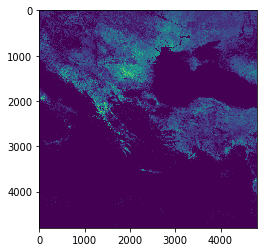

In [18]:
if check_results:
    
    import matplotlib
    import matplotlib.pyplot as plt

    fig = plt.figure()
    plt.imshow(snow_ndays)
    plt.show()

##### Write image

In [19]:

snow_ndays_img_name = 'snow_ndays' + '_' + nameOfRegion['value'] + '_' + dates[0] + '_' + dates[-1] + '.tif'
snow_ndays_img_name = os.path.join(output_folder, snow_ndays_img_name)

write_output_image(snow_ndays_img_name, snow_ndays, 'GTiff', gdal.GDT_UInt16, None, projection, geotransform, no_data_value)


#### Remove temporay files and folders

In [20]:
rm_cfolder(temp_folder)

os.rmdir(temp_folder)